# Traditional NLP & ML approach
## 1. Data Preprocessing

In [1]:
import pandas as pd
import re
from collections import Counter

import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
import torch
from torch.nn.functional import softmax, cross_entropy
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW

from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

/Users/Sigrid/Desktop/DSML/projects/project-nlp-automated-customer-reviews/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
data1 = pd.read_csv('data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')
data2 = pd.read_csv('data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')
data3 = pd.read_csv('data/1429_1.csv', low_memory=False)

In [3]:
# Align columns
cat_pc1 = data1[['categories', 'primaryCategories']].drop_duplicates()
cat_pc2 = data2[['categories', 'primaryCategories']].drop_duplicates()
cat_pc = pd.concat([cat_pc1, cat_pc2], axis=0).drop_duplicates().reset_index(drop=True)
data3 = data3.merge(cat_pc, on='categories', how='left')
# will deal with missing primaryCategories later

columns_to_keep = ['id', 'name', 'categories', 'primaryCategories', 'reviews.id', 'reviews.text', 'reviews.rating', 'reviews.doRecommend']
data = pd.concat([data1[columns_to_keep], data2[columns_to_keep], data3[columns_to_keep]], axis=0).reset_index(drop=True)
data['reviews.text'] = data['reviews.text'].fillna('')
data.drop_duplicates(subset = columns_to_keep, inplace=True)
data.drop(data[data['reviews.rating'].isnull()].index, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
data['reviews.grade'] = data['reviews.rating'].apply(lambda x: 2 if x >=5 else (1 if x==4 else 0))

In [4]:
# check class balance
data['reviews.grade'].value_counts()/data.shape[0]

reviews.grade
2    0.690506
1    0.228555
0    0.080940
Name: count, dtype: float64

### 1.1 Data Cleaning

In [5]:
def clean_text(text):
    text = re.sub(r"[!\"#$%&()*+,-./:;<=>?@[\\\]^_`{|}~]+", " ", text)  # remove punctuation
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = re.sub(r"\s+", " ", text).strip()  # remove extra whitespaces
    text = text.lower()
    return text

### 1.2 Tokenization and Lemmatization

In [6]:
## Tokenize the cleaned document
tokenized_doc = data['reviews.text'].apply(clean_text).fillna('').apply(lambda x: nlp(x))

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])

data["clean_token"] = [" ".join(x) for x in tokenized_doc]

### 1.3 Vectorization

In [8]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['clean_token'])

# X is a generator. We can transform that as an array
dense = X.toarray()
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(65481, 12870))

In [9]:
# SVD represent documents and terms in vectors
n_comp = 1000
svd_model = TruncatedSVD(n_components=n_comp, n_iter=100, random_state=122)
lsa = svd_model.fit_transform(X)

topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_"+str(i) for i in range(1, n_comp+1)])

print(n_comp, svd_model.explained_variance_ratio_.sum())

1000 0.8222728813330156


## 2. Model Building
### 2.1 Model Selection

In [ ]:
# handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(topic_encoded_df, data['reviews.grade'])

# split the data
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)

models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {"C": [0.1, 1, 10]}),
    "SVM": (SVC(), {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [100, 200, 300], "max_depth": [5, 10, 20]}),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), {"n_estimators": [100, 200, 300], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 6, 9]})
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, (model, params) in models.items():
    grid = GridSearchCV(model, params, cv=cv, scoring="f1_macro", n_jobs=-1)
    grid.fit(X_train, y_train)  # y is your label (e.g., 'positive', 'neutral', 'negative')
    
    print(f"\n {name} Best Parameters: {grid.best_params_}")
    print(f"{name} Classification Report:")
    print(classification_report(y_val, grid.predict(X_val), digits=4))

## 3. Model Evaluation
### 3.1 Evaluation Metrics

In [ ]:
# selected model: logistic regression with C=10
lr = LogisticRegression(C=10, max_iter=1000)
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)

# Detailed per-class report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.7374    0.8382    0.7846      6782
           1     0.5932    0.5310    0.5604      6783
           2     0.6771    0.6554    0.6661      6782

    accuracy                         0.6749     20347
   macro avg     0.6692    0.6749    0.6703     20347
weighted avg     0.6692    0.6749    0.6703     20347



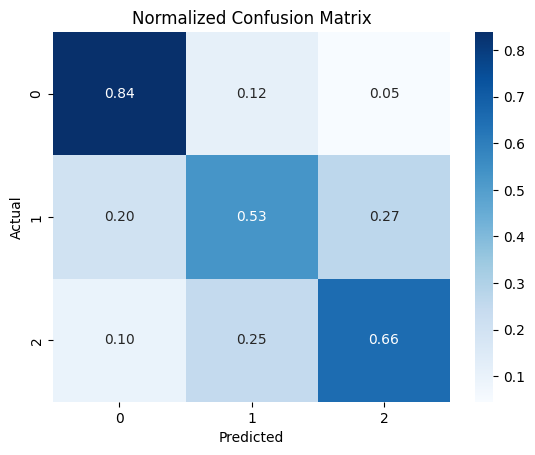

In [ ]:
cm = confusion_matrix(y_test, y_test_pred, labels=lr.classes_)
# Normalize by row (true class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.show()

### 3.2 Results
- Model achieves an accuracy of 67.49% on the test dataset.
- Precision, recall and F1-score for each class are as follows:
- - Class Positive: Precision = ...

# Transformer approach (HuggingFace)
## 1. Data Preprocessing

In [ ]:
# Cleaning, Tokenization and Encoding
data['clean_text'] = data['reviews.text'].apply(clean_text)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenized = tokenizer(
    data['clean_text'].to_list(), 
    padding=True, 
    truncation=True, 
    max_length=128, 
    return_tensors=None)

In [ ]:
# convert the above into tensors
input_ids = torch.tensor(tokenized["input_ids"])
attention_mask = torch.tensor(tokenized["attention_mask"])
labels = torch.tensor(data['reviews.grade'].tolist()) 

In [ ]:
# Split data
X = {"input_ids": input_ids, "attention_mask": attention_mask}
y = labels

X_train_ids, X_temp_ids, X_train_mask, X_temp_mask, y_train, y_temp = train_test_split(X["input_ids"], X["attention_mask"], y, test_size=0.3, stratify=y, random_state=42)
X_val_ids, X_test_ids, X_val_mask, X_test_mask, y_val, y_test = train_test_split(X_temp_ids, X_temp_mask, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

train_data = {
    "input_ids": X_train_ids,
    "attention_mask": X_train_mask,
    "labels": y_train
}

val_data = {
    "input_ids": X_val_ids,
    "attention_mask": X_val_mask,
    "labels": y_val
}

test_data = {
    "input_ids": X_test_ids,
    "attention_mask": X_test_mask,
    "labels": y_test
}

In [ ]:
# Wrap tensors into datasets
train_dataset = TensorDataset(train_data["input_ids"], train_data["attention_mask"], train_data["labels"])
val_dataset = TensorDataset(val_data["input_ids"], val_data["attention_mask"], val_data["labels"])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, drop_last=True)

# Create DataLoaders for the test set
test_dataset = TensorDataset(test_data["input_ids"], test_data["attention_mask"], test_data["labels"])
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.should_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
                
def train(model, train_loader, val_loader, criterion, optimizer, epochs=20, device = 'cpu'):
    model.to(device)
    # Dictionary to store training & validation loss and accuracy over epochs
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'val_f1': [], 'weighted avg': [], 'confusion matrix': []}
    # apply early stoppping
    early_stopper = EarlyStopping(patience = 5, min_delta=0)

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        for batch in train_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            # Get predicted class indices
            predicted = torch.argmax(outputs.logits, dim=1)
            # Compare with true labels
            correct += (predicted == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [x.to(device) for x in batch]
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()
                val_predicted = torch.argmax(outputs.logits, dim=1)
                val_correct += (val_predicted==labels).sum().item()

                val_preds.extend(val_predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        cr = classification_report(val_labels, val_preds, digits=4, output_dict=True)
        wavg = cr['weighted avg']
        mavg = cr['macro avg']
        cm = confusion_matrix(val_labels, val_preds)

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        history['val_f1'].append(mavg['f1-score'])
        history['weighted avg'].append(wavg)
        history['confusion matrix'].append(cm)

        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {mavg['f1-score']:.4f}")
        print(f"    Weighted avg -- Precision: {wavg['precision']:.4f}, Recall: {wavg['recall']:.4f}, F1-score: {wavg['f1-score']:.4f}")
        print(f"    Macro avg    -- Precision: {mavg['precision']:.4f}, Recall: {mavg['recall']:.4f}, F1-score: {mavg['f1-score']:.4f}")

        early_stopper(val_loss)
        if early_stopper.should_stop:
            print("Early stopping triggered.")
            break
    return history
        

### 2.1 Model Selection

In [ ]:
# model without fine-tuning
woft_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

woft_model.eval()

# generate test set evaluation
woft_model.eval()
woft_model.to(device)
test_preds, test_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        outputs = woft_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predicted class indices
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        
# classification report for the test set
cr_woft = classification_report(test_labels, test_preds, digits=4)
print("\nTest Set Classification Report:")
print(cr_woft)  

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Test Set Classification Report:
              precision    recall  f1-score   support

           0     0.0686    0.0441    0.0537       794
           1     0.0000    0.0000    0.0000      2243
           2     0.6913    0.9493    0.8000      6771

    accuracy                         0.6590      9808
   macro avg     0.2533    0.3311    0.2846      9808
weighted avg     0.4828    0.6590    0.5567      9808



/Users/Sigrid/Desktop/DSML/projects/project-nlp-automated-customer-reviews/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/Sigrid/Desktop/DSML/projects/project-nlp-automated-customer-reviews/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/Sigrid/Desktop/DSML/projects/project-nlp-automated-customer-reviews/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0

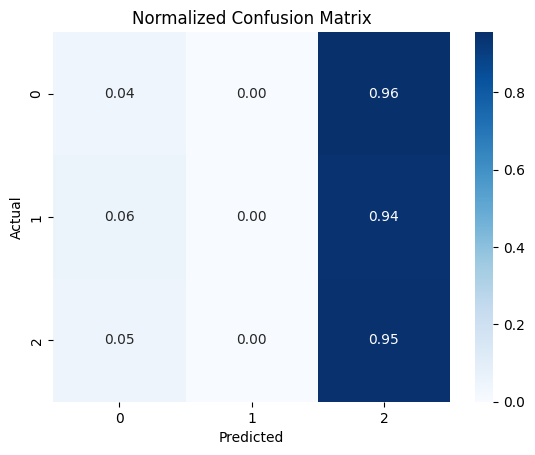

In [ ]:
cm_woft = confusion_matrix(test_labels, test_preds)
cm_woft_normalized = cm_woft.astype('float') / cm_woft.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_woft_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.show()

### 2.2 Model Fine-Tuning
Although the model is named as base_model, below process actually already integrates the fine-tuning process where the weights are updated. So please treat base_mdoel as fine-tuned model.

In [ ]:
# Load model and set up optimizer and scheduler
base_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

optimizer = AdamW(base_model.parameters(), lr=2e-5)

num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label_count = {i: 0 for i in range(3)}
for ii, am, labels in train_loader:
    batch_count = Counter(labels.tolist())
    for i in range(3):
        label_count[i] += batch_count[i]

total = sum(label_count.values())

weights = torch.tensor([
    total / label_count[i] for i in range(len(label_count))
], dtype=torch.float)

criterion = torch.nn.CrossEntropyLoss(weight = weights.to(device))

In [ ]:
history_base = train(base_model, train_loader, val_loader, criterion, optimizer)

Epoch [1/20] | Loss: 0.7504 | Acc: 0.6645 | Val Loss: 0.6874 | Val Acc: 0.6749 | Val F1: 0.6585
    Weighted avg -- Precision: 0.7535, Recall: 0.6759, F1-score: 0.6970
    Macro avg    -- Precision: 0.6628, Recall: 0.6876, F1-score: 0.6585
Epoch [2/20] | Loss: 0.5851 | Acc: 0.7338 | Val Loss: 0.6436 | Val Acc: 0.7338 | Val F1: 0.6742
    Weighted avg -- Precision: 0.7584, Recall: 0.7348, F1-score: 0.7427
    Macro avg    -- Precision: 0.6443, Recall: 0.7215, F1-score: 0.6742
Epoch [3/20] | Loss: 0.4540 | Acc: 0.7915 | Val Loss: 0.6569 | Val Acc: 0.7844 | Val F1: 0.7231
    Weighted avg -- Precision: 0.7873, Recall: 0.7855, F1-score: 0.7860
    Macro avg    -- Precision: 0.7098, Recall: 0.7388, F1-score: 0.7231
Epoch [4/20] | Loss: 0.3431 | Acc: 0.8414 | Val Loss: 0.6939 | Val Acc: 0.7923 | Val F1: 0.7414
    Weighted avg -- Precision: 0.8033, Recall: 0.7934, F1-score: 0.7973
    Macro avg    -- Precision: 0.7245, Recall: 0.7619, F1-score: 0.7414
Epoch [5/20] | Loss: 0.2548 | Acc: 0.881

In [ ]:
# Save model checkpoint 
checkpoint_path = "fine_tuned_model.pth"
torch.save({
    'model_state_dict': base_model.state_dict(),
    'optimizer_state_dict': base_model.state_dict(),
    'val_loss': history_base["val_loss"][-1],
    'confusion_matrix': history_base['confusion matrix'][-1]
}, checkpoint_path)

base_model.save_pretrained("model_dir")
tokenizer.save_pretrained("model_dir")

In [ ]:
# generate test set evaluation
base_model.eval()
base_model.to(device)
test_preds, test_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        outputs = base_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predicted class indices
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        
# classification report for the test set
cr_base = classification_report(test_labels, test_preds, digits=4)
print("\nTest Set Classification Report:")
print(cr_base)  


Test Set Classification Report:
              precision    recall  f1-score   support

           0     0.6847    0.8159    0.7445       793
           1     0.6071    0.6439    0.6249      2241
           2     0.8949    0.8568    0.8754      6774

    accuracy                         0.8049      9808
   macro avg     0.7289    0.7722    0.7483      9808
weighted avg     0.8121    0.8049    0.8076      9808



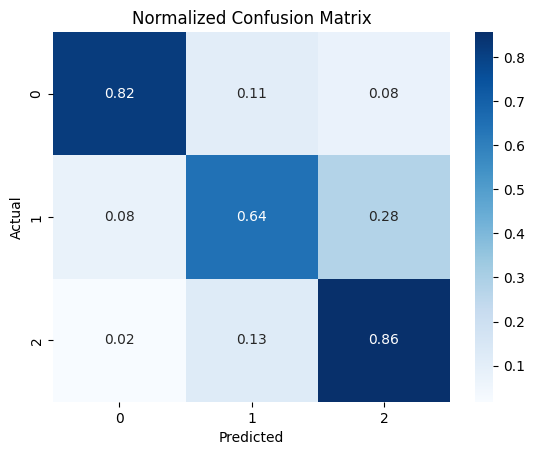

In [ ]:
cm_base = confusion_matrix(test_labels, test_preds)
cm_base_normalized = cm_base.astype('float') / cm_base.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_base_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.show()

## 3. Deal with Missing primaryCategories

In [ ]:
## Tokenize the cleaned document
tokenized_doc = cat_pc['categories'].apply(clean_text).fillna('').apply(lambda x: nlp(x))

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])

cat_pc["clean_token"] = [" ".join(x) for x in tokenized_doc]

# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(cat_pc['clean_token'])

# X is a generator. We can transform that as an array
dense = X.toarray()
dense

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.11244596, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(77, 253))

In [ ]:
# SVD represent documents and terms in vectors
n_comp = 20
svd_model = TruncatedSVD(n_components=n_comp, n_iter=100, random_state=122)
lsa = svd_model.fit_transform(X)

topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_"+str(i) for i in range(1, n_comp+1)])

print(n_comp, svd_model.explained_variance_ratio_.sum())

20 0.8428239440120587


In [ ]:
# encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(cat_pc['primaryCategories'])
cat_pc['pc_encoded'] = y_encoded

# handle class imbalance with SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
try:
    X_res, y_res = smote.fit_resample(topic_encoded_df, cat_pc['pc_encoded'])
except ValueError as e:
    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(topic_encoded_df, cat_pc['pc_encoded'])

# split the data
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {"C": [0.1, 1, 10]}),
    "SVM": (SVC(), {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [100, 200, 300], "max_depth": [5, 10, 20]}),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), {"n_estimators": [100, 200, 300], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 6, 9]})
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, (model, params) in models.items():
    grid = GridSearchCV(model, params, cv=cv, scoring="f1_macro", n_jobs=-1)
    grid.fit(X_train, y_train)  
    
    print(f"\n {name} Best Parameters: {grid.best_params_}")
    print(f"{name} Classification Report:")
    print(classification_report(y_val, grid.predict(X_val), digits=3))


 Logistic Regression Best Parameters: {'C': 10}
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        11
           1      1.000     0.455     0.625        11
           2      0.917     1.000     0.957        11
           3      0.750     1.000     0.857        12
           4      1.000     1.000     1.000        11
           5      1.000     1.000     1.000        11
           6      1.000     1.000     1.000        12
           7      1.000     1.000     1.000        11
           8      0.917     1.000     0.957        11
           9      1.000     1.000     1.000        11

    accuracy                          0.946       112
   macro avg      0.958     0.945     0.940       112
weighted avg      0.957     0.946     0.939       112


 SVM Best Parameters: {'C': 10, 'kernel': 'rbf'}
SVM Classification Report:
              precision    recall  f1-score   support

           0     

In [ ]:
test_pc = pd.DataFrame(data[data['primaryCategories'].isnull()]['categories'])

## Tokenize the cleaned document
tokenized_doc = test_pc['categories'].apply(clean_text).fillna('').apply(lambda x: nlp(x))
# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
test_pc["clean_token"] = [" ".join(x) for x in tokenized_doc]

# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(test_pc['clean_token'])

# SVD represent documents and terms in vectors
n_comp = 20
svd_model = TruncatedSVD(n_components=n_comp, n_iter=100, random_state=122)
lsa = svd_model.fit_transform(X)
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_"+str(i) for i in range(1, n_comp+1)])

In [ ]:
pc_model = RandomForestClassifier(n_estimators=100, max_depth=10)
pc_model.fit(X_train, y_train)

y_test_pred = pc_model.predict(topic_encoded_df)
data.loc[data['primaryCategories'].isnull(), 'primaryCategories'] = le.inverse_transform(y_test_pred)

## 4. Push model to huggingface hub

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("model_dir")
tokenizer = AutoTokenizer.from_pretrained("model_dir")
model.push_to_hub("yang181614/customer-review-distilbert")
tokenizer.push_to_hub("yang181614/customer-review-distilbert")

Processing Files (1 / 1): 100%|██████████|  268MB /  268MB,  312MB/s  
New Data Upload: |          |  0.00B /  0.00B,  0.00B/s  
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/yang181614/customer-review-distilbert/commit/f1a014eb9bb554b1a013ec622a000c44a37ffb58', commit_message='Upload tokenizer', commit_description='', oid='f1a014eb9bb554b1a013ec622a000c44a37ffb58', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yang181614/customer-review-distilbert', endpoint='https://huggingface.co', repo_type='model', repo_id='yang181614/customer-review-distilbert'), pr_revision=None, pr_num=None)